In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball as pyb
import matplotlib as mpl

In [311]:
# Define font properties for general text
font_properties = {'family': 'DejaVu Sans', 'size': 12}

# Define font properties for titles
font_properties_titles = {'family': 'DejaVu Sans', 'size': 20}

# Define font properties for axes labels
font_properties_axes = {'family': 'DejaVu Sans', 'size': 16}

# Set the theme for seaborn plots
sns.set_theme(style='whitegrid', 
              palette='deep', 
              font='DejaVu Sans', 
              font_scale=1.5, 
              color_codes=True, 
              rc=None)

# Import matplotlib


# Set the resolution of the figures to 300 DPI
mpl.rcParams['figure.dpi'] = 300

In [312]:
import pybaseball as pyb
print(pyb.playerid_lookup('Judge','Aaron'))

  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0     judge      aaron     592450  judga001  judgeaa01          15640   

   mlb_played_first  mlb_played_last  
0            2016.0           2024.0  


In [313]:
print(pyb.playerid_lookup('Ramírez','José'))
batter_id = 608070
df_pyb = pyb.statcast_batter('2024-03-28', '2024-10-01', batter_id)
sorted_columns = sorted(df_pyb.columns)
print(sorted_columns)
# df_pyb.head()

  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0   ramírez       josé     542432  ramij004  ramirjo02          10171   
1   ramírez       josé     608070  ramij003  ramirjo01          13510   

   mlb_played_first  mlb_played_last  
0            2014.0           2018.0  
1            2013.0           2024.0  
Gathering Player Data
['age_bat', 'age_bat_legacy', 'age_pit', 'age_pit_legacy', 'api_break_x_arm', 'api_break_x_batter_in', 'api_break_z_with_gravity', 'arm_angle', 'at_bat_number', 'away_score', 'away_team', 'ax', 'ay', 'az', 'babip_value', 'balls', 'bat_score', 'bat_score_diff', 'bat_speed', 'bat_win_exp', 'batter', 'batter_days_since_prev_game', 'batter_days_until_next_game', 'bb_type', 'break_angle_deprecated', 'break_length_deprecated', 'delta_home_win_exp', 'delta_pitcher_run_exp', 'delta_run_exp', 'des', 'description', 'effective_speed', 'estimated_ba_using_speedangle', 'estimated_slg_using_speedangle', 'estimated_woba_using_speedangle', 'events',

In [314]:
def df_processing_hitter(df_pyb: pd.DataFrame):
    df = df_pyb.copy()
    
    # Define codes for different hitting outcomes
    swing_code = ['foul_bunt', 'foul', 'hit_into_play', 'swinging_strike', 'foul_tip',
                  'swinging_strike_blocked', 'missed_bunt', 'bunt_foul_tip']
    contact_code = ['foul', 'hit_into_play']  # Contact includes foul balls and balls in play
    hard_hit_code = ['line_drive', 'fly_ball']  # Example of hard-hit indicators, if available

    # Create new columns in the DataFrame to indicate hitting performance
    df['swing'] = df['description'].isin(swing_code)  # Indicates if the hitter swung
    df['contact'] = df['description'].isin(contact_code)  # Indicates if contact was made
    df['whiff'] = df['description'].isin(['swinging_strike', 'foul_tip', 'swinging_strike_blocked'])  # Missed swing
    df['chase'] = (df['zone'] > 10) & df['swing']  # Swing at a pitch outside the zone (chase)
    df['in_play'] = df['description'] == 'hit_into_play'  # Ball hit into play

    # Calculate additional metrics for hitter
    df['barrel'] = (df['launch_speed'] > 98) & (df['launch_angle'].between(10, 25))  # Barrelled ball
    df['hard_hit'] = df['launch_speed'] > 95  # Hard-hit ball
    
    # Optional: Convert pitch movement to inches
    df['pfx_z'] = df['pfx_z'] * 12  # Vertical movement in inches
    df['pfx_x'] = df['pfx_x'] * 12  # Horizontal movement in inches

    # Filter out unnecessary rows or NaN values if needed
    df.dropna(subset=['description', 'zone'], inplace=True)

    return df

# Example usage
df = df_processing_hitter(df_pyb)


In [315]:
# Aggregate metrics for a hitter
total_pitches = len(df)
swing_rate = df['swing'].mean() * 100
contact_rate = df['contact'].mean() * 100
whiff_rate = df['whiff'].mean() * 100
chase_rate = df['chase'].mean() * 100
barrel_rate = df['barrel'].mean() * 100
hard_hit_rate = df['hard_hit'].mean() * 100

# Print hitter card stats
print(f"Total Pitches: {total_pitches}")
print(f"Swing Rate: {swing_rate:.2f}%")
print(f"Contact Rate: {contact_rate:.2f}%")
print(f"Whiff Rate: {whiff_rate:.2f}%")
print(f"Chase Rate: {chase_rate:.2f}%")
print(f"Barrel Rate: {barrel_rate:.2f}%")
print(f"Hard-Hit Rate: {hard_hit_rate:.2f}%")


Total Pitches: 2735
Swing Rate: 49.43%
Contact Rate: 41.90%
Whiff Rate: 7.50%
Chase Rate: 16.64%
Barrel Rate: 3.14%
Hard-Hit Rate: 12.07%


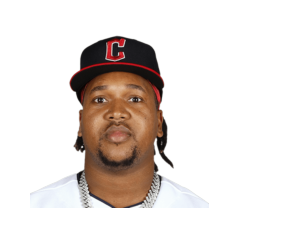

In [316]:
from PIL import Image
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Function to get an image from a URL and display it on the given axis
def player_headshot(batter_id: str, ax: plt.Axes):
    # Construct the URL for the player's headshot image
    url = f'https://img.mlbstatic.com/mlb-photos/image/'\
          f'upload/d_people:generic:headshot:67:current.png'\
          f'/w_640,q_auto:best/v1/people/{batter_id}/headshot/silo/current.png'

    # Send a GET request to the URL
    response = requests.get(url)

    # Open the image from the response content
    img = Image.open(BytesIO(response.content))


    # Display the image on the axis
    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0, 1, 0, 1], origin='upper')

    # Turn off the axis
    ax.axis('off')


# Call the player_headshot function with the pitcher ID and current axis
player_headshot(batter_id=batter_id, ax=plt.subplots(figsize=(1, 1))[1])

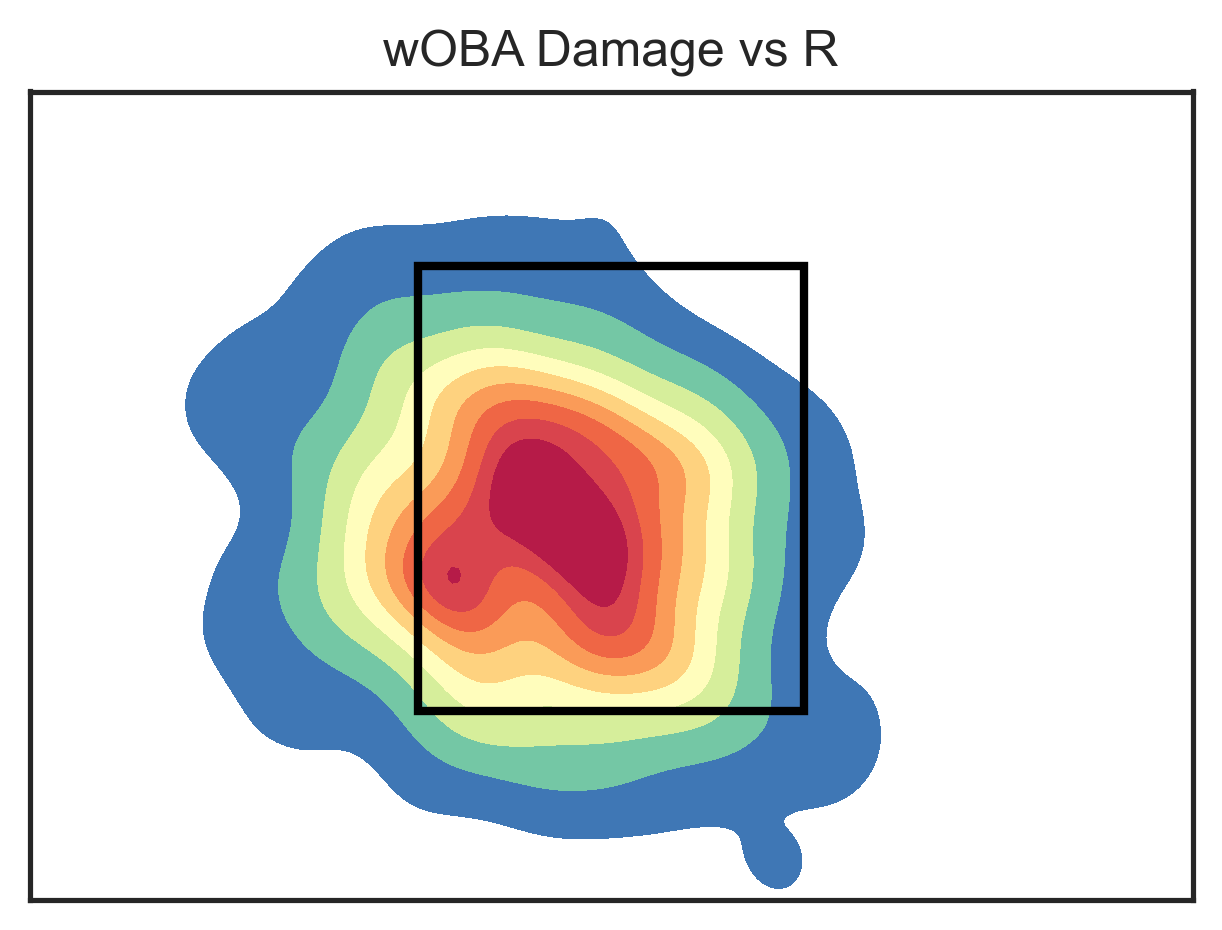

In [332]:
import matplotlib.patches as patches

filtered_df = df_pyb[(df_pyb['plate_x'].notnull()) & (df_pyb['plate_z'].notnull()) & (df_pyb['woba_value'].notnull()) & (df_pyb['p_throws'] == 'R')]


plate_damage_df = pd.DataFrame({
    'plate_x': filtered_df['plate_x'],
    'plate_z': filtered_df['plate_z'],
    'damage': filtered_df['woba_value']
})

# Define the corner coordinates for the rectangle
min_plate_x = -0.83
max_plate_x = 0.83
min_plate_z = 1.17
max_plate_z = 3.92

# Create the heatmap (you can use hexbin or kdeplot as shown earlier)
plt.figure(figsize=(5, 3.5))

# KDE plot with plate_x and plate_z as the axes, and damage as the color
sns.kdeplot(data=plate_damage_df, x='plate_x', y='plate_z', cmap='Spectral_r', fill=True, cbar=False, bw_adjust=.9)

# Create a rectangle using the given corner coordinates
rectangle = patches.Rectangle(
    (min_plate_x, min_plate_z),  # Lower left corner
    max_plate_x - min_plate_x,   # Width
    max_plate_z - min_plate_z,   # Height
    linewidth=2,                 # Line width
    edgecolor='black',             # Rectangle border color
    facecolor='none',            # No fill color inside the rectangle
    linestyle='-'               # Dotted line style
)

plt.gca().add_patch(rectangle)
plt.xlim(-2.5, 2.5)
plt.ylim(0,5)
plt.xticks([])  # Remove x-axis numbers
plt.yticks([])  # Remove y-axis numbers
plt.grid(False)
# Optionally, remove spines for a cleaner look
sns.set(style="white")

# Add labels and title
plt.title("wOBA Damage vs R")
plt.xlabel("")
plt.ylabel("")

# Show the plot
plt.show()

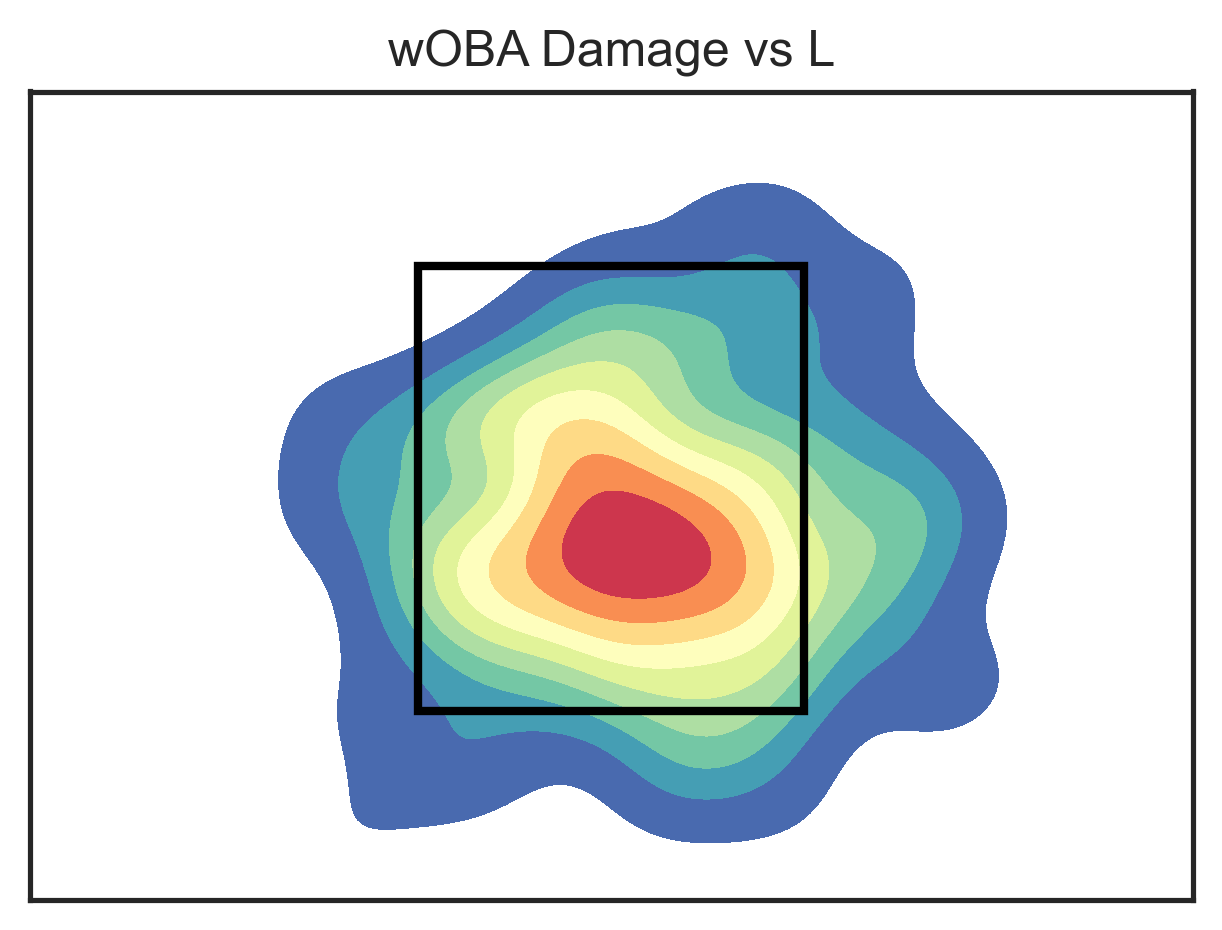

In [331]:

import matplotlib.patches as patches

filtered_df = df_pyb[(df_pyb['plate_x'].notnull()) & (df_pyb['plate_z'].notnull()) & (df_pyb['woba_value'].notnull()) & (df_pyb['p_throws'] == 'L')]


plate_damage_df = pd.DataFrame({
    'plate_x': filtered_df['plate_x'],
    'plate_z': filtered_df['plate_z'],
    'damage': filtered_df['woba_value']
})

# Define the corner coordinates for the rectangle
min_plate_x = -0.83
max_plate_x = 0.83
min_plate_z = 1.17
max_plate_z = 3.92

# Create the heatmap (you can use hexbin or kdeplot as shown earlier)
plt.figure(figsize=(5, 3.5))

# KDE plot with plate_x and plate_z as the axes, and damage as the color
sns.kdeplot(data=plate_damage_df, x='plate_x', y='plate_z', cmap='Spectral_r', fill=True, cbar=False, bw_adjust=.9)

# Create a rectangle using the given corner coordinates
rectangle = patches.Rectangle(
    (min_plate_x, min_plate_z),  # Lower left corner
    max_plate_x - min_plate_x,   # Width
    max_plate_z - min_plate_z,   # Height
    linewidth=2,                 # Line width
    edgecolor='black',             # Rectangle border color
    facecolor='none',            # No fill color inside the rectangle
    linestyle='-'               # Dotted line style
)

plt.gca().add_patch(rectangle)
plt.xlim(-2.5, 2.5)
plt.ylim(0,5)
plt.xticks([])  # Remove x-axis numbers
plt.yticks([])  # Remove y-axis numbers
plt.grid(False)
# Optionally, remove spines for a cleaner look
sns.set(style="white")

# Add labels and title
plt.title("wOBA Damage vs L")
plt.xlabel("")
plt.ylabel("")

# Show the plot
plt.show()
